### 기본 세팅

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('../'))

from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
from tokenization_kbalbert import KbAlbertCharTokenizer
from transformers import pipeline, AutoModelForSequenceClassification

In [2]:
# 종목 vcoab은 종목명 유의어까지 포함
vocab = [
    ['삼성전자', '삼전'],
    ['SK하이닉스', '하닉'],
    ['카카오뱅크', '카뱅'],
    ['두산중공업', '두중'],
    ['HMM', '흠'],
    ['SK바이오사이언스', 'sk바이오', 'sk바사'],
    ['한국전력공사', '한국전력', '한전'],
    ['카카오'],
    ['대한항공', '댄공']
]

# 분석할 날짜 입력
period = ['20210822', '20210823', '20210824', '20210825', '20210826']
targetdate = '20210826'

# 오늘의 해시태그, 오해 불용어 정의
OHAE_stopwords = []
with open('./OHAE_stopwords.txt', 'r', encoding='UTF8') as file:
    for line in file:
        OHAE_stopwords.append(line.strip())

for i in range(len(vocab)):
    for j in range(len(vocab[i])):
        stockname = vocab[i][j]
        token = Okt().morphs(stockname)
        for voca in token:
            OHAE_stopwords.append(voca)

### 텍스트 분석 클래스

In [3]:
class Analyzer:
    def __init__(self, **kwargs):
        super(Analyzer, self).__init__(**kwargs)
        
        # 데이터 출처별 언급량 스코어 
        self.mention_score_daumnews  = [0.5, 0.1]          #제목, 댓글 언급 스코어
        self.mention_score_dcinside  = [0.5, 0.4, 0.1]     #제목, 본문, 댓글 언급 스코어
        self.mention_score_jongto    = [0.5, 0.4, 0.1]     #제목, 본문, 댓글 언급 스코어
        self.mention_score_navernews = [0.5, 0.1]          #제목, 댓글 언급 스코어
        self.mention_score_youtube   = [0.5, 0.1]          #제목, 댓글 언급 스코어
        
        # 사용한 데이터 출처
        self.datafrom = ['daumnews', 'dcinside', 'jongto', 'navernews', 'youtube']
        
    
    
    # 언급량 측정: 네이버뉴스, 다음뉴스, 유튜브
    def estimate_mentioned1(self, datafrom, info, comment, keywords):
        mentioned_headline = 0
        mentioned_comment = 0
        
        # 데이터 출처에 따른 mention score 지정
        if datafrom == 'navernews':
            mention_score = self.mention_score_navernews
        elif datafrom == 'daumnews':
            mention_score = self.mention_score_daumnews
        elif datafrom == 'youtube':
            mention_score = self.mention_score_youtube
            
        # 언급량 카운트
        for keyword in keywords:
            # 제목에서 언급량
            keyword_count = 0
            for i in range(len(list(info['제목']))):
                if keyword in list(info['제목'])[i]:
                    keyword_count += 1
                else:
                    keyword_count += 0.5
            mentioned_headline += mention_score[0] * keyword_count
            
            # 댓글에서 언급량
            keyword_count = 0
            for i in range(len(list(comment['댓글']))):
                if keyword in list(comment['댓글'])[i]:
                    keyword_count += 1
                else:
                    keyword_count += 0.5
            mentioned_comment += mention_score[1] * keyword_count
        return mentioned_headline + mentioned_comment
    
    
    
    # 언급량 측정: 디시인사이드, 종토방
    def estimate_mentioned2(self, datafrom, info, comment, keywords):
        mentioned_headline = 0
        mentioned_content = 0
        mentioned_comment = 0
        
        # 데이터 출처에 따른 mention score 지정
        if datafrom == 'dcinside':
            mention_score = self.mention_score_dcinside
        elif datafrom == 'jongto':
            mention_score = self.mention_score_jongto
            
        # 언급량 카운트
        for keyword in keywords:
            # 제목에서 언급량
            keyword_count = 0
            for i in range(len(list(info['제목']))):
                if keyword in list(info['제목'])[i]:
                    keyword_count += 1
                else:
                    keyword_count += 0.5
            mentioned_headline += mention_score[0] * keyword_count
            
            # 본문에서 언급량
            keyword_count = 0
            for i in range(len(list(info['본문']))):
                if keyword in list(info['본문'])[i]:
                    keyword_count += 1
                else:
                    keyword_count += 0.5
            mentioned_content += mention_score[1] * keyword_count
            
            # 댓글에서 언급량
            keyword_count = 0
            for i in range(len(list(comment['댓글']))):
                if keyword in list(comment['댓글'])[i]:
                    keyword_count += 1
                else:
                    keyword_count += 0.5
            mentioned_comment += mention_score[2] * keyword_count         
        return mentioned_headline + mentioned_content + mentioned_comment
    
    
    
    # 날짜별 데이터 통합
    def select_datacolumns(self, date, keyword):
        datafrom = self.datafrom
        datacolumns = []
        
        # 같은 날짜에서 5개 데이터 통합
        for i in range(len(datafrom)):
            if (datafrom[i] == 'youtube') and (keyword == '한국전력공사'):
                keyword = '한국전력'
            
            globals()[f'info{i}'] = globals()[f'{datafrom[i]}_{date}_{keyword}_final_info']
            globals()[f'comment{i}'] = globals()[f'{datafrom[i]}_{date}_{keyword}_final_comment']
            
            if (datafrom[i] == 'navernews') or (datafrom[i] == 'daumnews') or (datafrom[i] == 'youtube'):
                datacolumns.append(list(globals()[f'info{i}']['제목']))
                datacolumns.append(list(globals()[f'comment{i}']['댓글']))
            elif (datafrom[i] == 'dcinside') or (datafrom[i] == 'jongto'):
                datacolumns.append(list(globals()[f'info{i}']['제목']))
                datacolumns.append(list(globals()[f'info{i}']['본문']))
                datacolumns.append(list(globals()[f'comment{i}']['댓글']))    
        return datacolumns
                
    
    
    # 오늘의 해시태그, 오해 선정
    def select_OHAE(self, datacolumns):
        word2index = {}
        bow = []
        
        # 데이터프레임을 돌며 단어 수집
        for datacolumn in datacolumns:
            for headline in datacolumn:
                token = Okt().nouns(headline)
                for voca in token:
                    if voca in OHAE_stopwords or voca.isdigit():
                        continue

                    if voca not in word2index:
                        word2index[voca] = len(word2index)
                        bow.insert(len(word2index)-1, 1)
                    else:
                        index = word2index[voca]
                        bow[index] = bow[index]+1

        # 단어 빈도수 리스트 형성
        word_count = []
        for i in range(len(bow)):
            word = list(word2index.keys())[i]
            count = bow[i]
            word_count.append([count, word])
        word_count.sort(reverse=True)
        return word_count[:5]
    
    
    
    # 특정 키워드가 있는 텍스트를 모두 가져옴(글 길이 상관 없음)
    def data_extraction(self, df, keyword):
        main_text = []
        for text in list(df['document'].values):
            if keyword in text:
                main_text.append(text)
        print(keyword, '이(가) 포함된', len(main_text),'개의 텍스트가 모여짐')
        return main_text


    
    # 특정 키워드가 있는 텍스트를 모두 가져옴(글 길이를 600개 이하로 끊음)
    def data_extraction_for_classifier(self, df, keyword):
        main_text = []
        for text in list(df['document'].values):
            if keyword in text:
                main_text.append(text[:600])
        print(keyword, '이(가) 포함된', len(main_text),'개의 텍스트가 모여짐')
        return main_text
    
    
    
    # 오늘의 해시태그, 오해 연관어 추출
    def word2vec_OHAE(self, OHAE, dataframe):
        print('----------------------'*5)
        print(OHAE, '이(가) 포함된 텍스트에 벡터라이징 적용')
        text_with_OHAE = self.data_extraction(dataframe, OHAE)

        # 불용어 및 제외어 정의
        stopwords = ['삼','전','성','등','되다','전자','삼성','삼전','있다','에서','이다','을','기','의','가','이','은','들',
                     '는','좀','잘','걍','식','과','월','도','임','20만원','배','를','으로','자','에','와','한','하다',
                     '더','게','것','*','1','2','3','4','5','6','7','8','g','크다','아니다','지금','대비','때','율',
                     '위','올해','연말','분기','특별']
        removewords = ['향후', '종목', '및', '이유','저가','고가']
        
        # 토큰화
        tokenized_data = []
        for sentence in text_with_OHAE:
            temp_X = Okt().nouns(sentence) 
            temp_X = [word for word in temp_X if not word in stopwords] 
            tokenized_data.append(temp_X)

        # 토큰을 임베딩하여 벡터라이징
        model = Word2Vec(sentences=tokenized_data, window=6, min_count=5, workers=4, sg=0)
        
        # 코사인 유사도를 기준으로 하여 OHAE 단어와 가장 가까운 단어 상위 20개 뽑음
        OHAE_word2vec_dict = model.wv.most_similar(OHAE, topn=20)
        print('----------------------'*5)
        print('벡터라이징 결과(코사인 유사도 값 확인) :')
        print(OHAE_word2vec_dict)
        
        # 제외어를 제외시켜 최종 연관어 도출
        OHAE_word2vec_list = []
        for ranks in range(len(OHAE_word2vec_dict)):
            OHAE_word2vec_list.append(OHAE_word2vec_dict[ranks][0])
            if OHAE_word2vec_dict[ranks][0] in removewords:
                OHAE_word2vec_list.remove(OHAE_word2vec_dict[ranks][0])
        
        print('\n최종 연관어 리스트: ', OHAE_word2vec_list)
        return OHAE_word2vec_list

    
    
    # 오늘의 해시태그, 오해 연관어 감성분석
    def sentiment_analysis(self, OHAE_word2vec_list, dataframe):
        OHAE_top4_relationword = OHAE_word2vec_list[:4]
        print('----------------------'*5)   
        print('연관어 4개: ', OHAE_top4_relationword)
        print('----------------------'*5)    
        
        for 연관어 in OHAE_top4_relationword:
            # 오해 단어의 연관어가 포함된 텍스트만 추출
            OHAE_top4_Text = self.data_extraction_for_classifier(dataframe, 연관어)

            # 학습된 albert모델 불러와 사용
            kb_albert_model_path = './model'
            model_output_path = './OHAE_project/model_output'
            model = AutoModelForSequenceClassification.from_pretrained(model_output_path)
            # kbalberrCharTokenizer을 이용해 텍스트 토큰화
            tokenizer = KbAlbertCharTokenizer.from_pretrained(kb_albert_model_path)

            # 10일치의 텍스트가 학습된 감성분석 모델을 사용해 모든 텍스트에 대해서 positive/negative 예측
            comment_classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, framework='pt')
            comments = OHAE_top4_Text

            # 감성분석 진행
            comments = comment_classifier(comments)
            positive = 0
            negative = 0
            total = len(comments) 
            for comment in comments:
                if comment['label'] == 'positive':
                    positive += 1
                if comment['label'] == 'negative':
                    negative += 1
            print(연관어,'의 긍정도: ', round(positive/total, 3))
            print(연관어,'의 부정도: ', round(negative/total, 3))
            print('----------------------'*5)

### 언급량 분석

In [4]:
# 다음뉴스 언급량 분석
datafrom = 'daumnews'

for date in period:
    # 언급량 변수
    globals()[f'mentioned_{datafrom}_{date}'] = []

    for i in range(len(vocab)):
        # 종목 선택
        keyword = vocab[i][0]

        # 데이터프레임 불러오기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_info.csv', index_col=0)
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_comment.csv', index_col=0)

        # 데이터프레임 빈 부분 채우기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['댓글'].isnull(), '댓글'] = ''

        # 언급량 계산
        keywords = vocab[i]
        info = globals()[f'{datafrom}_{date}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{date}_{keyword}_final_comment']
        globals()[f'mentioned_{datafrom}_{date}_{keyword}'] = Analyzer().estimate_mentioned1(datafrom, info, comment, keywords)
        globals()[f'mentioned_{datafrom}_{date}'].append([keyword, globals()[f'mentioned_{datafrom}_{date}_{keyword}']])
        #print(f' {date} {datafrom} {keyword} 언급량 분석 완료')

In [5]:
# 디시인사이드 언급량 분석
datafrom = 'dcinside'

for date in period:
    # 언급량 변수
    globals()[f'mentioned_{datafrom}_{date}'] = []

    for i in range(len(vocab)):
        # 종목 선택
        keyword = vocab[i][0]

        # 데이터프레임 불러오기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_info.csv', index_col=0)
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_comment.csv', index_col=0)

        # 데이터프레임 빈 부분 채우기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['본문'].isnull(), '본문'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['댓글'].isnull(), '댓글'] = ''

        # 언급량 계산
        keywords = vocab[i]
        info = globals()[f'{datafrom}_{date}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{date}_{keyword}_final_comment']
        globals()[f'mentioned_{datafrom}_{date}_{keyword}'] = Analyzer().estimate_mentioned2(datafrom, info, comment, keywords)
        globals()[f'mentioned_{datafrom}_{date}'].append([keyword, globals()[f'mentioned_{datafrom}_{date}_{keyword}']])
        #print(f' {date} {datafrom} {keyword} 언급량 분석 완료')

In [6]:
# 종토방 언급량 분석
datafrom = 'jongto'

for date in period:
    # 언급량 변수
    globals()[f'mentioned_{datafrom}_{date}'] = []

    for i in range(len(vocab)):
        # 종목 선택
        keyword = vocab[i][0]

        # 데이터프레임 불러오기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_info.csv', index_col=0)
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_comment.csv', index_col=0)

        # 데이터프레임 빈 부분 채우기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['본문'].isnull(), '본문'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['댓글'].isnull(), '댓글'] = ''

        # 언급량 계산
        keywords = vocab[i]
        info = globals()[f'{datafrom}_{date}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{date}_{keyword}_final_comment']
        globals()[f'mentioned_{datafrom}_{date}_{keyword}'] = Analyzer().estimate_mentioned2(datafrom, info, comment, keywords)
        globals()[f'mentioned_{datafrom}_{date}'].append([keyword, globals()[f'mentioned_{datafrom}_{date}_{keyword}']])
        #print(f' {date} {datafrom} {keyword} 언급량 분석 완료')

In [7]:
# 네이버뉴스 언급량 분석
datafrom = 'navernews'

for date in period:
    # 언급량 변수
    globals()[f'mentioned_{datafrom}_{date}'] = []

    for i in range(len(vocab)):
        # 종목 선택
        keyword = vocab[i][0]

        # 데이터프레임 불러오기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_info.csv', index_col=0)
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_comment.csv', index_col=0)

        # 데이터프레임 빈 부분 채우기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['댓글'].isnull(), '댓글'] = ''

        # 언급량 계산
        keywords = vocab[i]
        info = globals()[f'{datafrom}_{date}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{date}_{keyword}_final_comment']
        globals()[f'mentioned_{datafrom}_{date}_{keyword}'] = Analyzer().estimate_mentioned1(datafrom, info, comment, keywords)
        globals()[f'mentioned_{datafrom}_{date}'].append([keyword, globals()[f'mentioned_{datafrom}_{date}_{keyword}']])
        #print(f' {date} {datafrom} {keyword} 언급량 분석 완료')

In [8]:
# 유튜브 언급량 분석
datafrom = 'youtube'

for date in period:
    # 언급량 변수
    globals()[f'mentioned_{datafrom}_{date}'] = []

    for i in range(len(vocab)):
        # 종목 선택
        keyword = vocab[i][0]
        if keyword == '한국전력공사':
            keyword = '한국전력'

        # 데이터프레임 불러오기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_info.csv', index_col=0)
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'] = pd.read_csv(f'./{date}_data/{date}_{datafrom}/{datafrom}_{date}_{keyword}_final_comment.csv', index_col=0)

        # 데이터프레임 빈 부분 채우기
        globals()[f'{datafrom}_{date}_{keyword}_final_info'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_info']['제목'].isnull(), '제목'] = ''
        globals()[f'{datafrom}_{date}_{keyword}_final_comment'].loc[globals()[f'{datafrom}_{date}_{keyword}_final_comment']['댓글'].isnull(), '댓글'] = ''

        # 언급량 계산
        keywords = vocab[i]
        info = globals()[f'{datafrom}_{date}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{date}_{keyword}_final_comment']
        globals()[f'mentioned_{datafrom}_{date}_{keyword}'] = Analyzer().estimate_mentioned1(datafrom, info, comment, keywords)
        globals()[f'mentioned_{datafrom}_{date}'].append([keyword, globals()[f'mentioned_{datafrom}_{date}_{keyword}']])
        #print(f' {date} {datafrom} {keyword} 언급량 분석 완료')

In [9]:
# 날짜별 언급량 통합
for date in period:
    globals()[f'mentioned_{date}'] = globals()[f'mentioned_daumnews_{date}']
    for i in range(len(vocab)):
        globals()[f'mentioned_{date}'][i][1] = float(globals()[f'mentioned_{date}'][i][1])
    
    for datafrom in ['dcinside', 'jongto', 'navernews', 'youtube']:
        for i in range(len(vocab)):
            globals()[f'mentioned_{date}'][i][1] += float(globals()[f'mentioned_{datafrom}_{date}'][i][1])

In [10]:
mentioned_20210822     # 20210822 5개 데이터에서 각 종목 언급량

[['삼성전자', 424.95000000000005],
 ['SK하이닉스', 75.25],
 ['카카오뱅크', 155.4],
 ['두산중공업', 72.35000000000001],
 ['HMM', 258.40000000000003],
 ['SK바이오사이언스', 95.30000000000001],
 ['한국전력공사', 61.95],
 ['카카오', 135.25],
 ['대한항공', 15.95]]

In [11]:
mentioned_20210823     # 20210823 5개 데이터에서 각 종목 언급량

[['삼성전자', 389.75],
 ['SK하이닉스', 125.80000000000001],
 ['카카오뱅크', 217.25],
 ['두산중공업', 90.3],
 ['HMM', 674.35],
 ['SK바이오사이언스', 160.85000000000002],
 ['한국전력공사', 60.85],
 ['카카오', 157.45],
 ['대한항공', 37.0]]

In [12]:
# 종목별 언급량 통합
for date in period:
    for i in range(len(vocab)):
        keyword = vocab[i][0]
        
        if date == period[0]:
            globals()[f'mentioned_{keyword}_{period[0]}_to_{period[4]}'] = []
        globals()[f'mentioned_{keyword}_{period[0]}_to_{period[4]}'].append(globals()[f'mentioned_{date}'][i][1])

In [13]:
mentioned_삼성전자_20210822_to_20210826     # 20210822 부터 20210826 까지 5개 데이터에서 삼성전자 언급량

[424.95000000000005, 389.75, 907.25, 678.95, 517.3000000000001]

In [14]:
mentioned_SK하이닉스_20210822_to_20210826     # 20210822 부터 20210826 까지 5개 데이터에서 SK하이닉스 언급량

[75.25, 125.80000000000001, 148.95000000000002, 85.6, 103.05000000000001]

### 언급량 시각화

In [15]:
def visualize_mentioned_keyword_per_period(mentioned_keyword_period, keyword, period):
    font_path = './NanumBarunGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    
    plt.title(f'{keyword} {period[0]}~{period[4]} 언급량 추이', fontproperties=fontprop, fontsize=15)
    plt.plot(period, mentioned_keyword_period, color='#FF9B00')
    plt.yticks(color='w')
    plt.show()

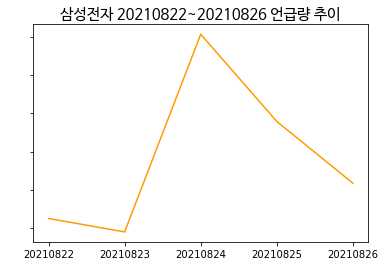

In [16]:
visualize_mentioned_keyword_per_period(mentioned_삼성전자_20210822_to_20210826, '삼성전자', period)

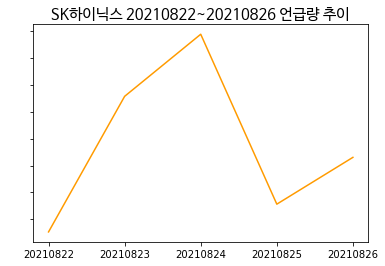

In [17]:
visualize_mentioned_keyword_per_period(mentioned_SK하이닉스_20210822_to_20210826, 'SK하이닉스', period)

### 오늘의 해시태그, 오해 선정

In [18]:
for i in range(len(vocab)):
    # 종목 선택
    keyword = vocab[i][0]
    
    # 데이터 칼럼 추출
    globals()[f'datacolumns_{targetdate}_{keyword}'] = Analyzer().select_datacolumns(targetdate, keyword)
    
    # 오늘의 해시태그, 오해 선정
    globals()[f'OHAE_{targetdate}_{keyword}'] = Analyzer().select_OHAE(globals()[f'datacolumns_{targetdate}_{keyword}'])

In [19]:
OHAE_20210826_삼성전자

[[89, '반도체'], [57, '이재용'], [52, '배당'], [51, '화이팅'], [48, '기업']]

In [20]:
OHAE_20210826_삼성전자 = [OHAE_20210826_삼성전자[0][1], OHAE_20210826_삼성전자[1][1], OHAE_20210826_삼성전자[2][1]]
OHAE_20210826_삼성전자

['반도체', '이재용', '배당']

In [21]:
OHAE_20210826_SK하이닉스

[[29, '이사'], [23, '네이버'], [18, '반도체'], [16, '전망'], [13, '합병']]

In [22]:
OHAE_20210826_SK하이닉스 = [OHAE_20210826_SK하이닉스[0][1], OHAE_20210826_SK하이닉스[1][1], OHAE_20210826_SK하이닉스[2][1]]
OHAE_20210826_SK하이닉스

['이사', '네이버', '반도체']

In [23]:
OHAE_20210826_카카오뱅크

[[42, '대출'], [32, '금융'], [29, '은행'], [27, '전망'], [16, '기업']]

In [24]:
OHAE_20210826_카카오뱅크 = [OHAE_20210826_카카오뱅크[0][1], OHAE_20210826_카카오뱅크[1][1], OHAE_20210826_카카오뱅크[2][1]]
OHAE_20210826_카카오뱅크

['대출', '금융', '은행']

### 오늘의 해시태그, 오해 연관어 추출 및 감성분석

In [25]:
# 오해 연관어를 추출할 네이버뉴스, 다음뉴스, 유튜브 제목/댓글 합산
for datafrom in ['navernews', 'daumnews', 'youtube']:
    for i in range(len(vocab)):
        cnt = 1
        keyword = vocab[i][0]
        if datafrom == 'youtube' and keyword == '한국전력공사':
            keyword = '한국전력'
            
        # 데이터프레임 칼럼 변경
        info = globals()[f'{datafrom}_{targetdate}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{targetdate}_{keyword}_final_comment']
        integrate = pd.DataFrame(index=range(len(info)+len(comment)))
        integrate['id'] = np.arange(len(integrate))
        integrate['document'] = list(info['제목']) + list(comment['댓글'])
        integrate['label'] = 0

        # 데이터프레임 통합
        if cnt == 1:
            globals()[f'전체2_{targetdate}_{keyword}'] = integrate
        else:
            globals()[f'전체2_{targetdate}_{keyword}'] = pd.concat([globals()[f'전체2_{targetdate}_{keyword}'], integrate], ignore_index=True)
        cnt += 1
        
# 오해 연관어를 추출할 디시인사이드, 종토방 제목/본문/댓글 합산
for datafrom in ['dcinside', 'jongto']:
    for i in range(len(vocab)):
        keyword = vocab[i][0]
       
        # 데이터프레임 칼럼 변경
        info = globals()[f'{datafrom}_{targetdate}_{keyword}_final_info']
        comment = globals()[f'{datafrom}_{targetdate}_{keyword}_final_comment']
        integrate = pd.DataFrame(index=range(len(info)*2+len(comment)))
        integrate['id'] = np.arange(len(integrate))
        integrate['document'] = list(info['제목']) + list(info['본문']) + list(comment['댓글'])
        integrate['label'] = 0
        
        # 데이터프레임 통합
        globals()[f'전체2_{targetdate}_{keyword}'] = pd.concat([globals()[f'전체2_{targetdate}_{keyword}'], integrate], ignore_index=True)
        
# 오해 연관어를 추출할 전체 데이터프레임
for i in range(len(vocab)):
    keyword = vocab[i][0]
    
    # 결측치 포함 행 제거
    globals()[f'전체2_{targetdate}_{keyword}'].dropna(axis=0, inplace=True)
    globals()[f'전체2_{targetdate}_{keyword}'].set_index(np.arange(len(globals()[f'전체2_{targetdate}_{keyword}'])), inplace=True)
    globals()[f'전체2_{targetdate}_{keyword}']['id'] = np.arange(len(globals()[f'전체2_{targetdate}_{keyword}']))
    
    # 파일 저장
    #globals()[f'전체2_{date}_{keyword}'].to_csv(f'./전체2_{date}_{keyword}_labelling.csv', index=None, encoding='utf-8-sig')

In [26]:
전체2_20210826_삼성전자     # 삼성전자 오해 연관어를 뽑을 20210816 5개 데이터 통합 데이터프레임

,id,document,label
0,0,삼성전자 2차 폭락 언제든 올 수 있다 이렇게 대비하세요,0
1,1,삼성전자 폴더블폰 흥행 대박 관련 수혜주는 삼성전자 주가하락 이유 주식누나분석,0
2,2,삼성전자 주식 언제 사야할까요 주식 초보자라면 반드시 알아야할 것,0
3,3,240조 투자 계획 이재용 부회장 행보로 이 종목 반드시 오른다 8월 황금 반도체 ...,0
4,4,특종 240조 투자 계획 이 종목으로 인생 역전 이재용 수혜 제대로 받을 8월 폭등...,0
...,...,...,...
1828,1828,말같은 소리를,0
1829,1829,쓰레기들,0
1830,1830,,0
1831,1831,외인평단이 71500원이넘는대 무슨 절대못빼요,0


In [27]:
OHAE_20210826_삼성전자

['반도체', '이재용', '배당']

In [28]:
relationword_list = Analyzer().word2vec_OHAE(OHAE_20210826_삼성전자[0], 전체2_20210826_삼성전자)
Analyzer().sentiment_analysis(relationword_list, 전체2_20210826_삼성전자)

--------------------------------------------------------------------------------------------------------------
반도체 이(가) 포함된 텍스트에 벡터라이징 적용
반도체 이(가) 포함된 48 개의 텍스트가 모여짐
--------------------------------------------------------------------------------------------------------------
벡터라이징 결과(코사인 유사도 값 확인) :
[('호재', 0.4483661651611328), ('스마트폰', 0.37818780541419983), ('랠리', 0.3695841133594513), ('주가', 0.3352426588535309), ('폭등', 0.33300772309303284), ('급등', 0.3184204399585724), ('발표', 0.3094865679740906), ('전망', 0.3066434860229492), ('이재용', 0.3036530017852783), ('미국', 0.2871244251728058), ('업계', 0.28091296553611755), ('성장', 0.27077025175094604), ('젠', 0.26876166462898254), ('하락', 0.25543731451034546), ('투자', 0.25348496437072754), ('실적', 0.24733957648277283), ('상승', 0.2411302924156189), ('최근', 0.2396106868982315), ('세계', 0.23921069502830505), ('점유', 0.23700480163097382)]

최종 연관어 리스트:  ['호재', '스마트폰', '랠리', '주가', '폭등', '급등', '발표', '전망', '이재용', '미국', '업계', '성장', '젠', '하락', '투자', '실적', '상승', '최근', 

In [29]:
relationword_list = Analyzer().word2vec_OHAE(OHAE_20210826_삼성전자[1], 전체2_20210826_삼성전자)
Analyzer().sentiment_analysis(relationword_list, 전체2_20210826_삼성전자)

--------------------------------------------------------------------------------------------------------------
이재용 이(가) 포함된 텍스트에 벡터라이징 적용
이재용 이(가) 포함된 34 개의 텍스트가 모여짐
--------------------------------------------------------------------------------------------------------------
벡터라이징 결과(코사인 유사도 값 확인) :
[('시스템', 0.20332562923431396), ('하락', 0.2023744285106659), ('전망', 0.17774972319602966), ('저가', 0.16716749966144562), ('실적', 0.14990536868572235), ('향후', 0.1481262445449829), ('폭등', 0.1262654960155487), ('주가', 0.09658350795507431), ('종목', 0.07115397602319717), ('스마트폰', 0.05259918048977852), ('증가', 0.024127941578626633), ('기회', 0.023797092959284782), ('공개', 0.02372214011847973), ('매수', 0.015612799674272537), ('단타', 0.013458438217639923), ('투자', 0.006858274340629578), ('부회장', 0.0055239819921553135), ('및', -0.00016371779202017933), ('이유', -0.00861575361341238), ('주식', -0.015027900226414204)]

최종 연관어 리스트:  ['시스템', '하락', '전망', '실적', '폭등', '주가', '스마트폰', '증가', '기회', '공개', '매수', '단타', '투자', '부회장', 

In [30]:
relationword_list = Analyzer().word2vec_OHAE(OHAE_20210826_삼성전자[2], 전체2_20210826_삼성전자)
Analyzer().sentiment_analysis(relationword_list, 전체2_20210826_삼성전자)

--------------------------------------------------------------------------------------------------------------
배당 이(가) 포함된 텍스트에 벡터라이징 적용
배당 이(가) 포함된 30 개의 텍스트가 모여짐
--------------------------------------------------------------------------------------------------------------
벡터라이징 결과(코사인 유사도 값 확인) :
[('스마트폰', 0.2818364202976227), ('시스템', 0.27878183126449585), ('이유', 0.2508566081523895), ('최근', 0.21830159425735474), ('최고', 0.21387705206871033), ('판매', 0.20607972145080566), ('목표', 0.19814155995845795), ('저렴', 0.17257656157016754), ('낙폭', 0.1687578558921814), ('상승', 0.1669282615184784), ('및', 0.1605823040008545), ('하락', 0.15915562212467194), ('대가', 0.1465504765510559), ('보통주', 0.1441357582807541), ('증가', 0.14410841464996338), ('주주', 0.14217019081115723), ('급등', 0.12817032635211945), ('대박', 0.11827577650547028), ('저가', 0.11178933829069138), ('우선주', 0.10841459035873413)]

최종 연관어 리스트:  ['스마트폰', '시스템', '최근', '최고', '판매', '목표', '저렴', '낙폭', '상승', '하락', '대가', '보통주', '증가', '주주', '급등', '대박', '우선주']
